## Setup and Configuration

In [251]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
from Bio import SeqIO

from alphagenome.visualization import plot_components
from alphagenome.models.dna_client import SUPPORTED_SEQUENCE_LENGTHS, OutputType
from alphagenome.models import dna_client
from alphagenome.data import genome, gene_annotation, transcript as transcript_utils

# Load config
config_name = 'LMNA_25'  # Change config file here
with open(f'config_private/{config_name}.json', 'r', encoding='utf-8') as f:
    cfg = json.load(f)

############################################################
# Output Parsing & Plotting
############################################################

def parse_output_types(output_type_names: List[str]):
    """Parse output type names from config into OutputType enums.

    Unsupported aliases are rejected with guidance.
    """

    output_types = []
    for name in output_type_names:
        name_upper = name.upper()
        if name_upper in {"SPLICE_JUNCTIONS", "SPLICE_SITES"}:
            raise ValueError(f"{name_upper} is not supported. Use SPLICE_SITE_USAGE instead.")
        if name_upper in OutputType.__members__:
            output_types.append(OutputType[name_upper])
        else:
            print(f"Warning: Unknown output type '{name}', skipping...")
    return output_types


def name_filter(names: List[str], substring: str) -> List[bool]:
    return [substring in n for n in names]


def filter_td(td, cfg):
    if cfg.get('track_filter'):
        td = td.filter_tracks(name_filter(td.names, cfg['track_filter']))
    if 'strand' in cfg:
        td = filter_by_strand(td, cfg['strand'])
    return td


def filter_by_strand(track_data, strand: str):
    """Apply strand selection to a TrackData object."""
    s = str(strand).lower()
    mapping = {
        '+': track_data.filter_to_positive_strand,
        '-': track_data.filter_to_negative_strand,
        'nonnegative': track_data.filter_to_nonnegative_strand,
        'nonpositive': track_data.filter_to_nonpositive_strand,
        'stranded': track_data.filter_to_stranded,
        'unstranded': track_data.filter_to_unstranded,
    }
    if s not in mapping:
        return track_data
    return mapping.get(s, lambda: track_data)()


def plot_all_outputs(output, transcripts, requested_outputs, cfg, interval, target_interval=None, variant=None):
    """Plot requested outputs with optional track/strand filtering."""
    for output_type in requested_outputs:
        if variant:
            ref_data = output.reference.get(output_type)
            alt_data = output.alternate.get(output_type)
            if ref_data is None or alt_data is None:
                continue
            tdata = {'REF': ref_data, 'ALT': alt_data}
            colors = {'REF': 'dimgrey', 'ALT': 'red'}
        else:
            track_data = output.get(output_type)
            if track_data is None:
                continue
            tdata = track_data
            colors = None

        # Apply filters
        if variant:
            tdata['REF'] = filter_td(tdata['REF'], cfg)
            tdata['ALT'] = filter_td(tdata['ALT'], cfg)
        else:
            tdata = filter_td(tdata, cfg)

        components = [plot_components.TranscriptAnnotation(transcripts)]
        annotations=[plot_components.IntervalAnnotation(target_interval)]
        if variant:
            components.append(plot_components.OverlaidTracks(tdata=tdata, colors=colors))
            annotations  = [plot_components.VariantAnnotation([variant], alpha=0.6), plot_components.IntervalAnnotation(target_interval)]
        else:
            components.append(plot_components.Tracks(tdata, ylabel_template='{biosample_name} ({strand})\n{name}'))

        plot_components.plot(
            components,
            interval=interval,
            title=f'{output_type.name}: {cfg["gene_symbol"]}',
            annotations=annotations,
        )
    plt.tight_layout()
    plt.show()
    return annotations


############################################################
# ASO Window & Variants
############################################################

def find_exon_sequence(interval_start: int, exon_intervals):
    s, e = int(exon_intervals[0]), int(exon_intervals[1])
    return s - interval_start, e - interval_start


def enumerate_aso_variants(ref_sequence: str, start: int, end: int, aso_length: int):
    """Generate ASO-masked variants by sliding an 'N' window.
    Ensures the sliding window stays within [start, end) bounds.
    """
    n_block = 'N' * aso_length
    variants = [ref_sequence[:i] + n_block + ref_sequence[i + aso_length:] for i in range(start, end)]
    asos = [ref_sequence[i:i + aso_length] for i in range(start, end)]
    return variants, asos


############################################################
# Scoring Utilities
############################################################

def diff_mean(ref: np.ndarray, alt: np.ndarray, start: int, end: int, gene_start: int, gene_end: int) -> np.ndarray:
    """Difference of means in [start:end]: alt - ref, normalized by gene body mean."""
    return alt[start:end].mean(0) / ref[gene_start:gene_end].mean(0) * alt[gene_start:gene_end].mean(0) - ref[start:end].mean(0)


def build_base_mask(sequence: str) -> np.ndarray:
    """One-hot mask for sequence bases (positions x 4)."""
    seq_np = np.array(list(sequence))
    return np.stack([seq_np == b for b in "ACGT"], -1)


def collapse_ism(ism_scores: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """Collapse per-variant scores to position/base via mask."""
    collapsed = np.zeros(mask.shape, dtype=ism_scores.dtype)
    collapsed[mask] = ism_scores
    return collapsed


############################################################
# Interval Sizing
############################################################

def get_optimal_resize_width(interval_width: int, config_resize: int | None = None) -> int:
    """Select an optimal resize width from supported lengths."""

    if config_resize is not None:
        return config_resize

    supported = sorted(SUPPORTED_SEQUENCE_LENGTHS.values())
    for length in supported:
        if length >= interval_width:
            return length

    max_len = supported[-1]
    print(f"⚠️ WARNING: Interval ({interval_width:,} bp) exceeds max supported ({max_len:,} bp). Using {max_len:,} bp; predictions will be truncated.")
    return max_len


############################################################
# Notebook Refactors: ASO scoring + BED export
############################################################

def score_asos(
    outputs,
    ref_output,
    requested_outputs,
    cfg,
    interval,
    variant_interval,
    asos,
    start: int,
    end: int,
    gene_start: int,
    gene_end: int,
    fasta_path: str,
    variant,
):
    """Compute ASO scores and create SeqLogo plots.

    Returns (results_df, plots_list).
    """

    plots = []
    results = pd.DataFrame(asos, columns=['ASO_sequence'])
    results['position'] = list(range(len(results)))

    ref_subseq = str(
        SeqIO.to_dict(SeqIO.parse(fasta_path, 'fasta'))[interval.chromosome]
        .seq[variant_interval.start:variant_interval.end]
    )
    mask = build_base_mask(ref_subseq)

    for output_type in requested_outputs:
        variant_array = []
        tds = []
        for i, output in enumerate(outputs):
            td = filter_td(output.get(output_type), cfg)
            if td is None:
                print(f"Skipping variant {i} for {output_type.name}: no tracks after filtering")
                continue
            variant_array.append(td.values.mean(axis=1))
            tds.append(td)

        if not variant_array:
            print(f"Skipping {output_type.name}: no variant tracks")
            continue

        variant_array = np.stack(variant_array, axis=1)

        if variant:
            ref_td_ref, ref_td = filter_td(ref_output.reference.get(output_type), cfg), filter_td(ref_output.alternate.get(output_type), cfg)
        else:
            ref_td = filter_td(ref_output.get(output_type), cfg)
            ref_td_ref = None
        if ref_td is None:
            print(f"Skipping {output_type.name}: missing reference output")
            continue

        aso_scores = diff_mean(ref_td.values.mean(axis=1)[:, None], variant_array, start, end, gene_start, gene_end)
        collapsed = collapse_ism(aso_scores, mask)
        results[f'ASO_{output_type.name}'] = aso_scores
        
        ylabel = f"{output_type.name.lower()}"
        plots.append(
            plot_components.SeqLogo(
                scores=collapsed,
                scores_interval=variant_interval,
                ylabel=ylabel,
                max_width=len(collapsed),
            ),
        )
        
        best = filter_td(tds[np.argmax(aso_scores)], cfg)
        worst = filter_td(tds[np.argmin(aso_scores)], cfg)
        if variant:
            tdata = {'REF':ref_td_ref, 'ALT': ref_td, 'POS': best, 'NEG': worst}
            colors = {'REF':'black', 'ALT':'green', 'POS':'red', 'NEG':'blue'}
        else:
            tdata = {'REF':ref_td, 'POS': best, 'NEG': worst}
            colors = {'REF':'black', 'POS':'red', 'NEG':'blue'}
        
        plots.append(plot_components.OverlaidTracks(tdata=tdata, colors=colors, ylabel_template='{biosample_name} ({strand})\n{name}'))

    return results, plots

def score_asos_and_export(
    outputs,
    ref_output,
    requested_outputs,
    cfg,
    interval,
    variant_interval,
    asos,
    samples_max,
    start: int,
    end: int,
    gene_start: int,
    gene_end: int,
    fasta_path: str,
    aso_length: int,
    results_dir: str,
    config_name: str,
    variant,
):
    """Compute ASO scores, create SeqLogo plots, and export BED files.

    Returns (results_df, plots_list).
    """

    results, plots = score_asos(
        outputs=outputs,
        ref_output=ref_output,
        requested_outputs=requested_outputs,
        cfg=cfg,
        interval=interval,
        variant_interval=variant_interval,
        asos=asos,
        start=start,
        end=end,
        gene_start=gene_start,
        gene_end=gene_end,
        fasta_path=fasta_path,
        variant=variant,
    )

    for output_type in requested_outputs:
        col = f'ASO_{output_type.name}'
        if col not in results.columns:
            continue

        top = results.sort_values(col, ascending=False).head(samples_max)
        top = top[top[col] > 0]
        bot = results.sort_values(col, ascending=True).head(samples_max)
        bot = bot[bot[col] < 0]
        full_top = results[results[col] > 0]
        full_bot = results[results[col] < 0]

        def build_df(sorted_results, invert: bool, full: bool = False) -> pd.DataFrame:
            scores = sorted_results[col]
            # Normalize colors safely
            norm_color = 1 + scores if invert else 1 - scores
            vals = (norm_color * 255).clip(1, 255)
            itemRgb = (
                [f'255,{int(v)},{int(v)}' for v in vals]
                if not invert else [f'{int(v)},{int(v)},255' for v in vals]
            )

            # BED coordinates: position is 0-based relative to variant_interval.start
            chrom_starts = variant_interval.start + sorted_results['position']
            chrom_ends = chrom_starts + aso_length
            df = pd.DataFrame({
                'chrom': [interval.chromosome] * len(sorted_results),
                'chromStart': chrom_starts,
                'chromEnd': chrom_ends,
                'name': [f"{'top' if not invert else 'bottom'}{i+1}({scores.iloc[i] * 100:.2f}%)" for i in range(len(sorted_results))], # if not full else [''] * len(sorted_results),
                'score': scores,
                'strand': interval.strand,
                'thickStart': chrom_starts,
                'thickEnd': chrom_ends,
                'itemRgb': itemRgb,
            })
            return df
        
        bed_df = pd.concat([build_df(top, False), build_df(bot, True)])
        full_top, full_bot = build_df(full_top, False, True), build_df(full_bot, True, True)
        full_df = pd.concat([full_top, full_bot])
        full_df[results[col] > 0] = full_top
        full_df[results[col] < 0] = full_bot
        
        with open(f"{results_dir}/{config_name}_ASO_{output_type.name}.bed", 'w') as f:
            f.write(
                f'track name={config_name}_ASO_{output_type.name} description="ASO scores for {output_type.name}" visibility="pack" useScore=1\n'
            )
            bed_df.to_csv(f, sep='\t', index=False, header=False)

        with open(f"{results_dir}/{config_name}_ASO_{output_type.name}_full.bed", 'w') as f:
            f.write(
                f'track name={config_name}_ASO_{output_type.name}_full description="Full ASO scores for {output_type.name}" visibility="pack" useScore=1\n'
            )
            full_df.to_csv(f, sep='\t', index=False, header=False)

    return results, plots

In [252]:
cfg['results_dir'] = cfg['results_dir'] + '/ASO'
Path(cfg['data_dir']).mkdir(parents=True, exist_ok=True)
Path(cfg['results_dir']).mkdir(parents=True, exist_ok=True)

# Initialize model and annotations
model = dna_client.create(cfg['dna_api_key'])
gtf = pd.read_feather(cfg['gtf_url'])
gene_interval = gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol'])

# Resize interval
config_resize = cfg.get('resize_width')
optimal_resize = get_optimal_resize_width(gene_interval.width, config_resize)
interval = gene_interval.resize(optimal_resize)

print(f"Gene: {cfg['gene_symbol']}")
print(f"Interval width: {gene_interval.width:,} bp | Resize: {optimal_resize:,} bp")

# Requested outputs
requested_outputs = parse_output_types(cfg.get('requested_outputs', ['RNA_SEQ', 'SPLICE_SITE_USAGE']))
print(f"Requested: {[ot.name for ot in requested_outputs]}")

# Transcripts
transcripts_df = gene_annotation.filter_to_mane_select_transcript(gene_annotation.filter_protein_coding(gtf))
transcripts = transcript_utils.TranscriptExtractor(transcripts_df).extract(gene_annotation.get_gene_interval(gtf, gene_symbol=cfg['gene_symbol']))

# Reference sequence (optionally apply SNV alt allele)
ref_seq = str(SeqIO.to_dict(SeqIO.parse(cfg['fasta_path'], 'fasta'))[interval.chromosome].seq[interval.start:interval.end])

# Exon interval (explicit)
target_interval = genome.Interval(
    chromosome=interval.chromosome,
    start=cfg['exon_intervals'][0],
    end=cfg['exon_intervals'][1],
    strand=interval.strand
)
exon_start_rel, exon_end_rel = find_exon_sequence(interval.start, cfg['exon_intervals'])
exon_start = interval.start + exon_start_rel
exon_end = interval.start + exon_end_rel
print(f"Target exon: {exon_start}-{exon_end}")

Gene: LMNA
Interval width: 57,510 bp | Resize: 131,072 bp
Requested: ['RNA_SEQ', 'SPLICE_SITE_USAGE']
Target exon: 156138607-156138644


## Step 1: Interval Prediction and Visualization

In [253]:
# Interval prediction or SNV-aware prediction
snv = cfg.get('snv', None)
variant = None
if snv:
    snv["chromosome"] = interval.chromosome
    if not snv.get('reference_bases'):
        snv['reference_bases'] = ref_seq[snv['position'] - interval.start]
    snv['position'] += 1 # Convert to 1-based
    variant = genome.Variant.from_dict(snv)
    ref_seq = ref_seq[:snv['position'] - interval.start] + snv['alternate_bases'] + ref_seq[snv['position'] - interval.start + len(snv['alternate_bases']):] 
    ref_output = model.predict_variant(
        interval=interval,
        variant=variant,
        requested_outputs=requested_outputs,
        ontology_terms=cfg['ontology_terms'],
    )
else:
    ref_output = model.predict_interval(
        interval=interval,
        requested_outputs=requested_outputs,
        ontology_terms=cfg['ontology_terms'],
    )

# Summary
for output_type in requested_outputs:
    if snv:
        track_data = ref_output.reference.get(output_type)
    else:
        track_data = ref_output.get(output_type)
    if track_data is not None and hasattr(track_data, 'values'):
        print(f"{output_type.name}: {track_data.values.shape} | {len(track_data.names)} tracks")

RNA_SEQ: (131072, 4) | 4 tracks
SPLICE_SITE_USAGE: (131072, 6) | 6 tracks


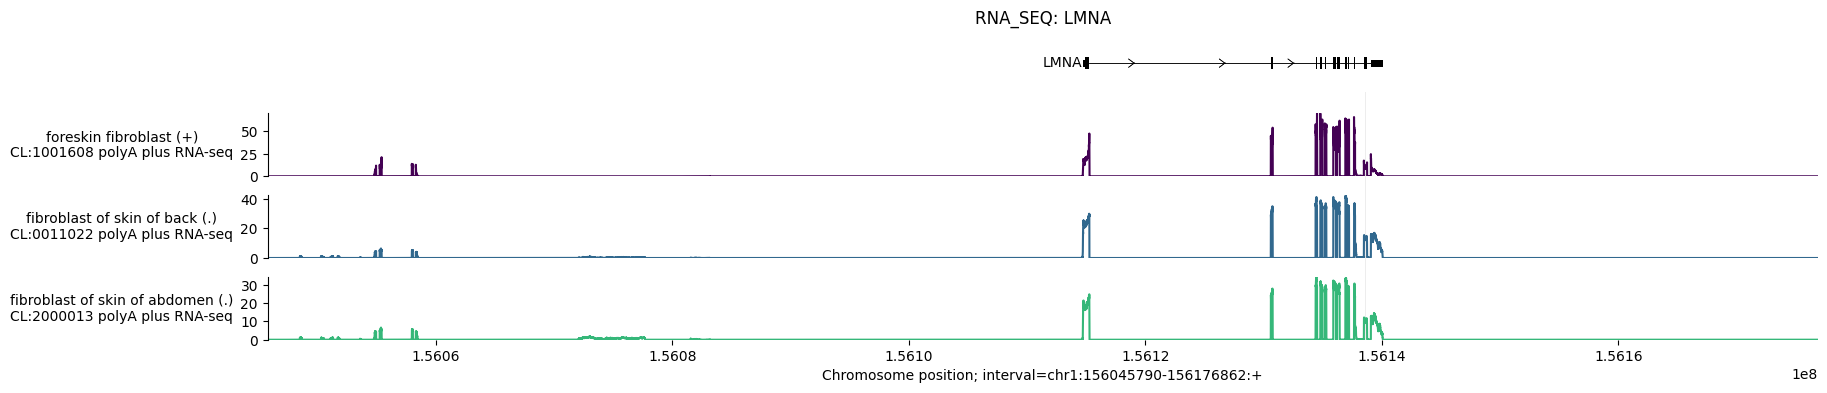

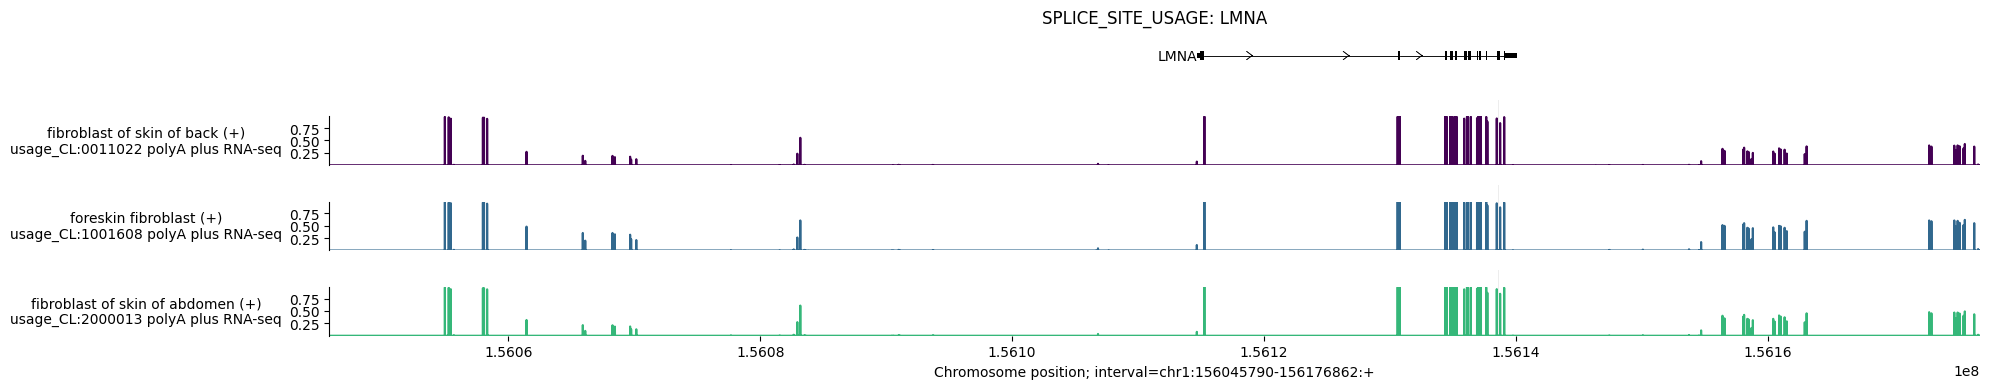

In [254]:
annotations = plot_all_outputs(ref_output, transcripts, requested_outputs, cfg, interval=interval, target_interval=[target_interval], variant=variant)

## Step 2: ASO Masking Experiments

In [255]:
# ASO variant window
variant_interval = genome.Interval(
    chromosome=interval.chromosome,
    start=exon_start-cfg['flank'][0],
    end=exon_end+cfg['flank'][1],
)
start_rel = variant_interval.start - interval.start
end_rel = variant_interval.end - interval.start
aso_length = cfg['ASO_length']
# Use ref_seq (which may have SNV alt applied) as reference for ASO enumeration


In [256]:
# Predict masked sequences
variants, asos = enumerate_aso_variants(ref_seq, start_rel, end_rel, aso_length)
print(f"ASO variants: {len(variants)} | length={aso_length} | window={variant_interval.start}-{variant_interval.end}")
outputs = model.predict_sequences(
    intervals=[interval] * len(variants),
    sequences=variants,
    requested_outputs=requested_outputs,
    ontology_terms=cfg['ontology_terms']
)
print(f"Predictions complete: {len(outputs)} sequences")

ASO variants: 637 | length=25 | window=156138507-156139144


  0%|          | 0/637 [00:00<?, ?it/s]

100%|██████████| 637/637 [01:29<00:00,  7.12it/s]

Predictions complete: 637 sequences


In [257]:
# ASO scoring, logos, and BED export
start = exon_start - interval.start
end = exon_end - interval.start
gene_start = gene_interval.start - interval.start
gene_end = gene_interval.end - interval.start

results, plots = score_asos_and_export(
    outputs=outputs,
    ref_output=ref_output,
    requested_outputs=requested_outputs,
    cfg=cfg,
    interval=interval,
    variant_interval=variant_interval,
    asos=asos,
    samples_max=20,
    start=start,
    end=end,
    gene_start=gene_start,
    gene_end=gene_end,
    fasta_path=cfg['fasta_path'],
    aso_length=aso_length,
    results_dir=cfg['results_dir'],
    config_name=config_name,
    variant=variant,
)

results.to_csv(f"{cfg['results_dir']}/{config_name}_ASO_scores.csv", index=False)
print(results.head())

                ASO_sequence  position  ASO_RNA_SEQ  ASO_SPLICE_SITE_USAGE
0  GGGGGACCCCGCTGAGTACAACCTG         0    -4.949706               0.000004
1  GGGGACCCCGCTGAGTACAACCTGC         1    -3.620374               0.000003
2  GGGACCCCGCTGAGTACAACCTGCG         2    -3.673415               0.000003
3  GGACCCCGCTGAGTACAACCTGCGC         3    -4.938395               0.000005
4  GACCCCGCTGAGTACAACCTGCGCT         4    -5.465798               0.000006


## Step 3: ASO Effect Scoring and Visualization

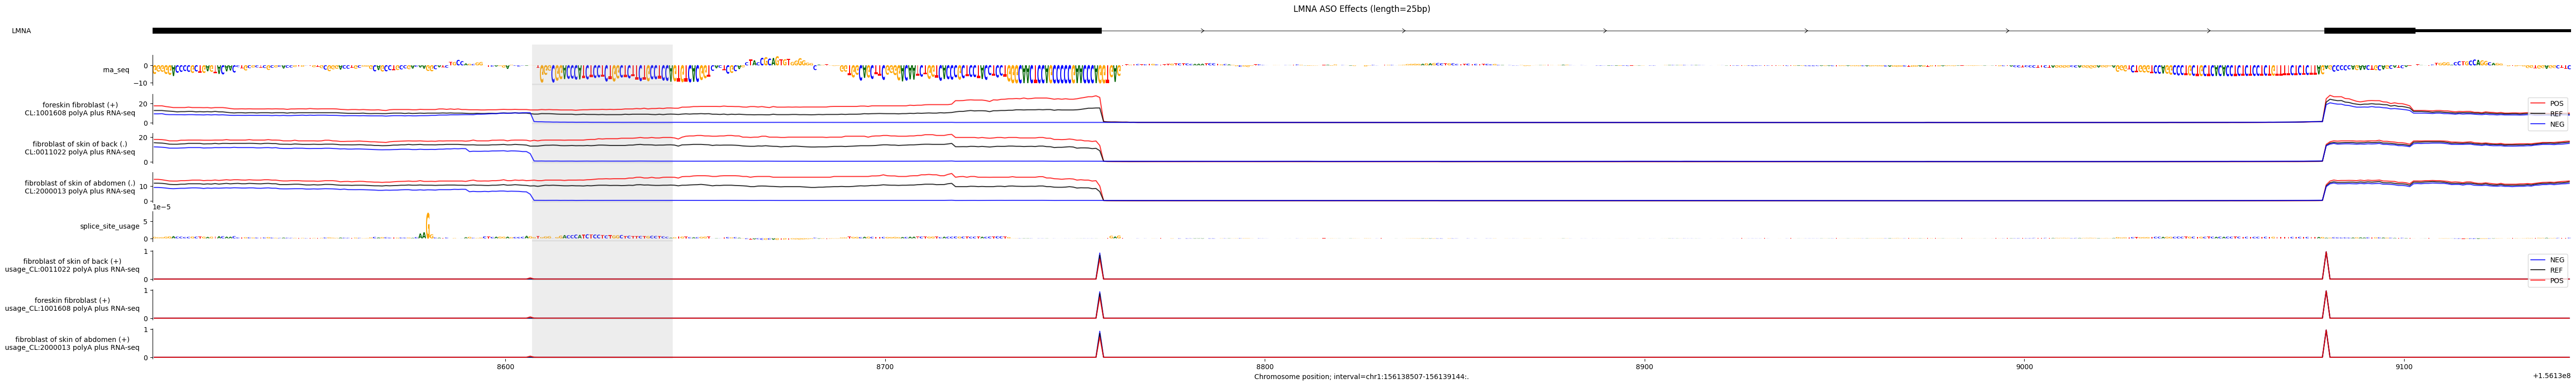

In [258]:
plot_components.plot(
    [plot_components.TranscriptAnnotation(transcripts)] + plots,
    interval=variant_interval,
    fig_width=variant_interval.width // 10,
    title=f"{cfg['gene_symbol']} ASO Effects (length={cfg['ASO_length']}bp)",
    annotations=annotations,
)
plt.show()